In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [3]:
data = pd.read_csv("lamoda_and_wb_reviews.csv")

In [4]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 7 else 0)

In [5]:
data

,Name,Description,Review,Rating,Sentiment
0,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Отличные кроссовки, очень лёгкие, на ножке акк...",10,1
1,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Красивые, стильные, удобные.",10,1
2,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,Все хорошо. Идет в размер,10,1
3,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Удобные и красивые, но вся грязь собирается на...",8,1
4,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,Удобные пока не носоли.,10,1
...,...,...,...,...,...
309405,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,Прекрасный звонок. У нас получилась дальность ...,10,1
309406,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,Всё супер. Звонок просто ВАУУУ,10,1
309407,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,"Классный звонок, сколько у нас из было,этот са...",10,1
309408,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,"Звенит звонко Нет Очень хороший звоночек, мн...",10,1


# SVM

In [6]:
data_clean = data.copy()

In [7]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(lambda x: count_russian_chars(str(x)))

In [8]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [9]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))
print(data_clean_russian.head())

                        Name  \
0  Кроссовки NIKE AIR MAX SC   
1  Кроссовки NIKE AIR MAX SC   
2  Кроссовки NIKE AIR MAX SC   
3  Кроссовки NIKE AIR MAX SC   
4  Кроссовки NIKE AIR MAX SC   

                                         Description  \
0  Кроссовки выполнены из натуральной кожи с текс...   
1  Кроссовки выполнены из натуральной кожи с текс...   
2  Кроссовки выполнены из натуральной кожи с текс...   
3  Кроссовки выполнены из натуральной кожи с текс...   
4  Кроссовки выполнены из натуральной кожи с текс...   

                                              Review  Rating  Sentiment  \
0  отличн кроссовк очен легк на ножк аккуратн смо...      10          1   
1                                красив стильн удобн      10          1   
2                            все хорош идет в размер      10          1   
3  удобн и красив но вся гряз собира на подошв и ...       8          1   
4                                 удобн пок не носол      10          1   

   Russian chars  


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [12]:
pipeline = Pipeline([
    ('tf-idf', TfidfVectorizer(ngram_range=(1,3))),
    ('clf', SVC(C=1, kernel='linear'))
])

In [13]:
pipeline.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', SVC(C=1, kernel='linear'))])

In [14]:
pred = pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.71      0.74      8298
           1       0.96      0.97      0.97     66610

    accuracy                           0.94     74908
   macro avg       0.86      0.84      0.85     74908
weighted avg       0.94      0.94      0.94     74908



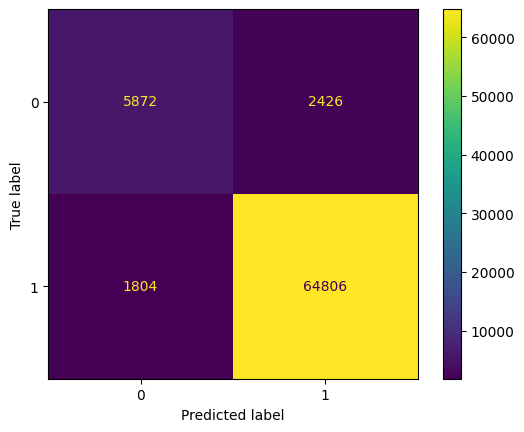

In [15]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test['Review'], y_test)

Добавим немного экспериментов с параметрами! Попробуем перейти на другое ядро - rbf, а также поиграться с параметром C.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

C = 1
              precision    recall  f1-score   support

           0       0.79      0.66      0.72      8298
           1       0.96      0.98      0.97     66610

    accuracy                           0.94     74908
   macro avg       0.87      0.82      0.84     74908
weighted avg       0.94      0.94      0.94     74908



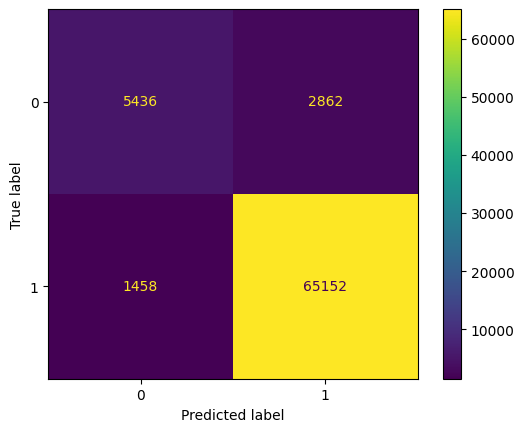

In [17]:
pipeline = Pipeline([
    ("tf-idf", TfidfVectorizer(ngram_range=(1, 3))),
    ("clf", SVC(C=1, kernel="rbf"))
])

print('='*50)
print("C = 1")
pipeline.fit(X_train["Review"], y_train)
pred = pipeline.predict(X_test["Review"])
print(classification_report(y_test, pred))
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test["Review"], y_test)
print('='*50)

C = 10
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      8298
           1       0.96      0.97      0.97     66610

    accuracy                           0.94     74908
   macro avg       0.87      0.83      0.85     74908
weighted avg       0.94      0.94      0.94     74908



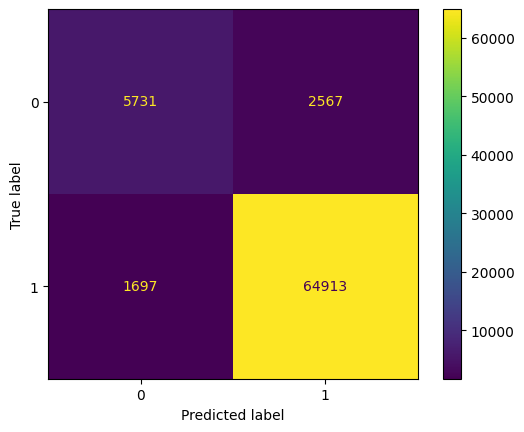

In [18]:
pipeline = Pipeline([
    ("tf-idf", TfidfVectorizer(ngram_range=(1, 3))),
    ("clf", SVC(C=10, kernel="rbf"))
])

print('='*50)
print("C = 10")
pipeline.fit(X_train["Review"], y_train)
pred = pipeline.predict(X_test["Review"])
print(classification_report(y_test, pred))
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test["Review"], y_test)
print('='*50)

# Итоги

## Linear kernel

              precision    recall  f1-score   support

           0       0.76      0.71      0.74      8298
           1       0.96      0.97      0.97     66610

## RBF kernel

* C = 1

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      8298
           1       0.96      0.98      0.97     66610

* C = 10

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      8298
           1       0.96      0.97      0.97     66610